In [1]:
from time import time
from collections import defaultdict, Counter

import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Считаем simhash-и.

In [2]:
%%time
with open("simhash_sorted.txt") as f:
    simhashes = [int(line[:-1]) for line in f.readlines()]
simhashes = np.array(simhashes, dtype=np.uint64)  # found out before that simhash fits uint64

CPU times: user 18 s, sys: 1.08 s, total: 19.1 s
Wall time: 19 s


In [3]:
SIMHASH_SIZE = 64
num_samples = len(simhashes)
print "Number of samples:", num_samples
print "SimHash example:", format(simhashes[0], "b")
print "SimHash size:", SIMHASH_SIZE

Number of samples: 33015945
SimHash example: 1000101011000111001001000001000101110101110110111111101010100101
SimHash size: 64


Поделим simhash-и на 4 части для индексирования.

In [4]:
MAX_DISTANCE = 3
NUM_PARTS = MAX_DISTANCE + 1
PART_SIZE = SIMHASH_SIZE / NUM_PARTS

In [12]:
neg_part_mask = "0" * PART_SIZE
pos_part_mask = "1" * PART_SIZE
masks = [neg_part_mask * part_id + pos_part_mask + neg_part_mask * (NUM_PARTS - part_id - 1)\
         for part_id in range(NUM_PARTS)]
masks = np.array([int(mask, 2) for mask in masks], dtype=np.uint64)

def get_part(simhash, part_id):
    return int(simhash & masks[part_id]) >> (PART_SIZE * (NUM_PARTS - part_id - 1))

In [13]:
%%time
simhashes_parts = np.zeros((len(simhashes), NUM_PARTS), dtype=np.int32)
for simhash_id, simhash in enumerate(simhashes):
    for part_id in xrange(NUM_PARTS):
        simhashes_parts[simhash_id][part_id] = get_part(simhash, part_id)

CPU times: user 1min 58s, sys: 332 ms, total: 1min 58s
Wall time: 1min 57s


Построим индексы.

In [32]:
%%time
indices = [[list() for __ in xrange(2 ** PART_SIZE)] for _ in xrange(NUM_PARTS)]
for simhash_id in xrange(num_samples):
    simhash_parts = simhashes_parts[simhash_id]
    for part_id in xrange(NUM_PARTS):
        indices[part_id][simhash_parts[part_id]].append(simhash_id)

CPU times: user 1min 3s, sys: 128 ms, total: 1min 3s
Wall time: 1min 3s


Прокластеризуем хеши.

In [33]:
def hamming(hash1, hash2):
    return bin(hash1 ^ hash2).count("1")

def similar(hash1, hash2):
    return hamming(hash1, hash2) <= MAX_DISTANCE

In [34]:
%%time
groups_sizes = []
visited = [False] * num_samples  # id-s of simhashes assigned to any of the considered groups
num_visited = 0

start = time()

for simhash_id, simhash in enumerate(simhashes):
    if visited[simhash_id]:
        continue
    
    group_size = 0
    simhash_parts = simhashes_parts[simhash_id]
    for part_id, part in enumerate(simhash_parts):
        for candidate_id in indices[part_id][part]:
            if visited[candidate_id]:
                continue
            if similar(simhash, simhashes[candidate_id]):
                group_size += 1
                visited[candidate_id] = True #.add(candidate_id)
                num_visited += 1
    
    groups_sizes.append(group_size)
    if simhash_id % 3000 == 0:
        spent = time() - start
        clear_output()
        print "Visited: {}\tRemained time: {:.2f} days".format(
            num_visited,(float(num_samples) / num_visited - 1) * spent / 60 / 60 / 24)

Visited: 726280	Remained time: 16.98 days


KeyboardInterrupt: 

Отработав 10 часов, скрипт обещал работать еще около 17 суток, что слишком долго. Поэтому проведём анализ уже полученных данных как репрезентативной выборки.

In [39]:
groups_sizes = np.array(groups_sizes)

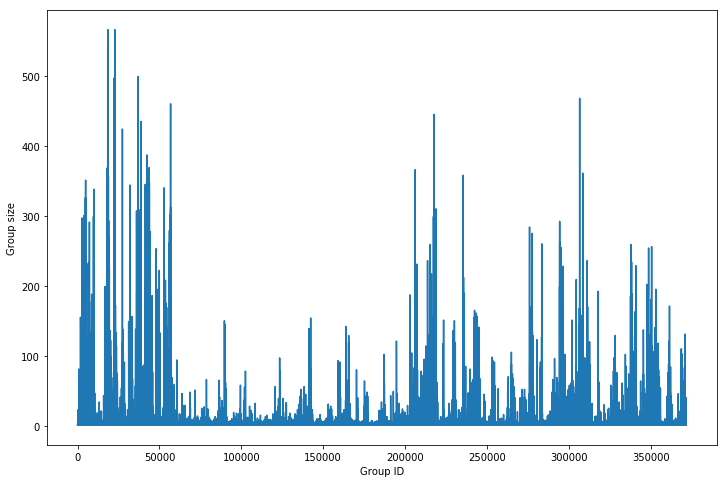

In [54]:
plt.figure(figsize=(12,8))
plt.plot(groups_sizes);
plt.xlabel("Group ID")
plt.ylabel("Group size");

Как видим, с течением времени в размере групп не наблюдается какого-либо тренда.

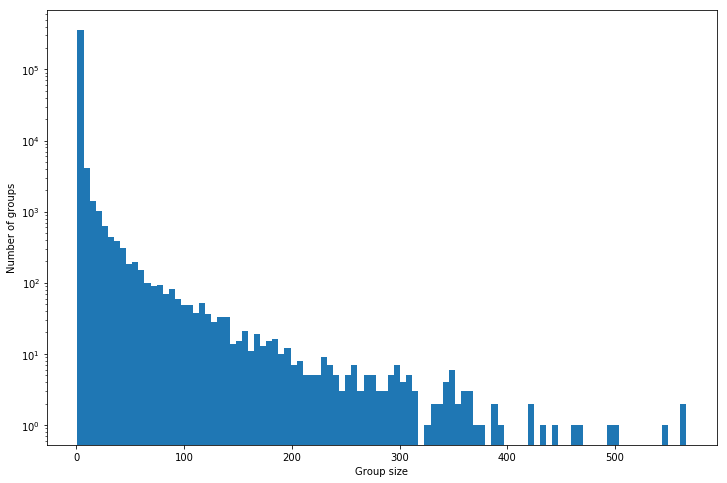

In [55]:
plt.figure(figsize=(12,8))
plt.hist(groups_sizes, bins=100, log=True)
plt.xlabel("Group size")
plt.ylabel("Number of groups");

На логарифмированной гистограмме распределения размеров групп видно, что тотальное преимущество за группами размера 1 и чем больше размер группы, тем меньше вероятность её встретить.